In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
def ma_model(epsilon_prev, const, theta, sigma2):
    """ X_t = const + epsilon_t + theta * epsilon_{t-1} """

    epsilon_t = np.random.normal(loc=0, scale=np.sqrt(sigma2))
    next_logr = const + epsilon_t + theta * epsilon_prev

    return next_logr

In [23]:
price_0 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_1/prices_round_1_day_0.csv', delimiter=';')

In [24]:
price_0 = price_0[price_0['product'] == 'SQUID_INK']
price_1 = price_1[price_1['product'] == 'SQUID_INK']
price_2 = price_2[price_2['product'] == 'SQUID_INK']

In [25]:
trades_0 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_1/trades_round_1_day_0.csv', delimiter=';')

In [26]:
trades_0 = trades_0[trades_0['symbol'] == 'SQUID_INK']
trades_1 = trades_1[trades_1['symbol'] == 'SQUID_INK']
trades_2 = trades_2[trades_2['symbol'] == 'SQUID_INK']

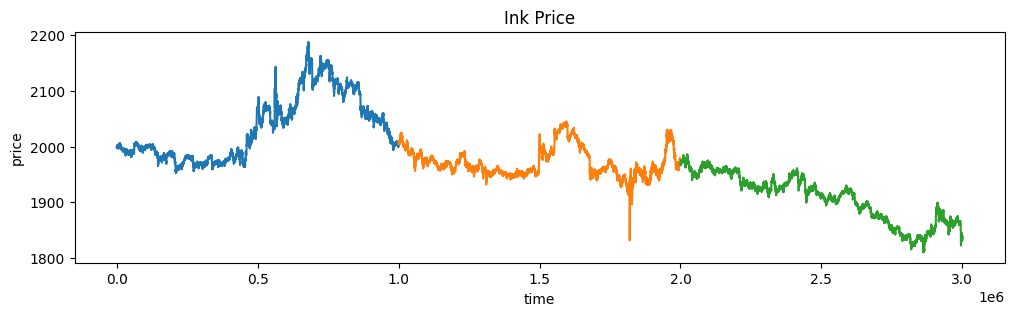

In [27]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [39]:
model = ARIMA(train_logr, order=(0, 0, 1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:                 ARIMA(0, 0, 1)   Log Likelihood                6671.914
Date:                Mon, 07 Apr 2025   AIC                         -13337.828
Time:                        15:04:39   BIC                         -13323.108
Sample:                             0   HQIC                        -13332.233
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.412e-06   3.66e-06     -0.385      0.700   -8.59e-06    5.77e-06
ma.L1         -0.6284      0.027    -22.947      0.000      -0.682      -0.575
sigma2      9.432e-08   3.64e-09     25.891      0.0

C:\Users\aeali\PycharmProjects\imc-prosperity-3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
result.params

array([-1.41204384e-06, -6.28382306e-01,  9.43236625e-08])

In [43]:
errs = [test_logr[0] - 0]
preds = [0]
for i in range(1, len(test_logr)):
    pred = ma_model(epsilon_prev=errs[i-1], const=result.params[0], theta=result.params[1], sigma2=result.params[2])
    err = test_logr[i] - pred
    preds.append(pred)
    errs.append(err)

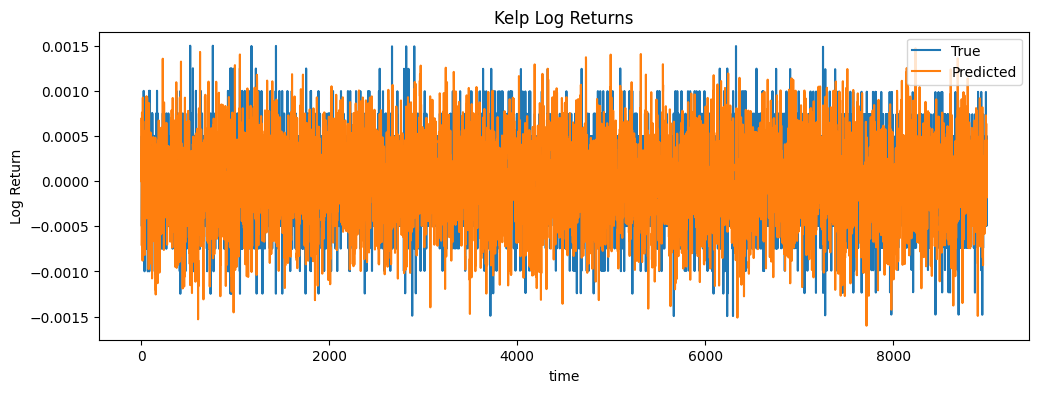

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(test_logr, label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [46]:
pred_price = test[:-1] * np.exp(preds)

In [47]:
err = test[1:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(rmse)

1.0183329077258367


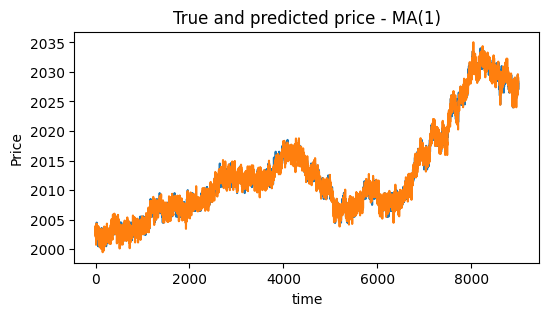

In [48]:
plt.figure(figsize=(6, 3))
plt.plot(test[1:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [8]:
bid_prices = price_0[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = price_0[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = price_0[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = price_0[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

price_0 = price_0.assign(pop_bid_price=pop_bid_prices)
price_0 = price_0.assign(pop_ask_price=pop_ask_prices)
price_0 = price_0.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [9]:
price = price_0.iloc[:200]

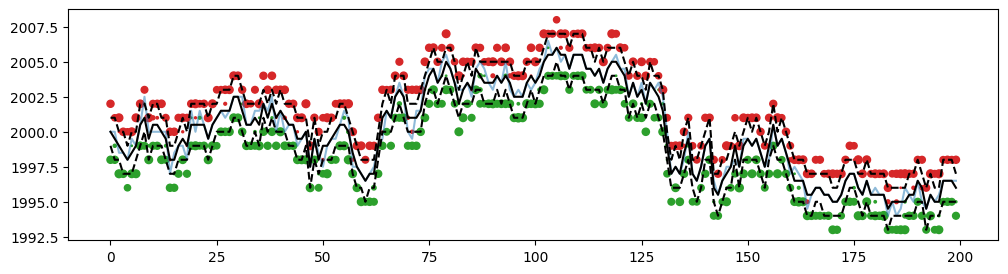

In [10]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

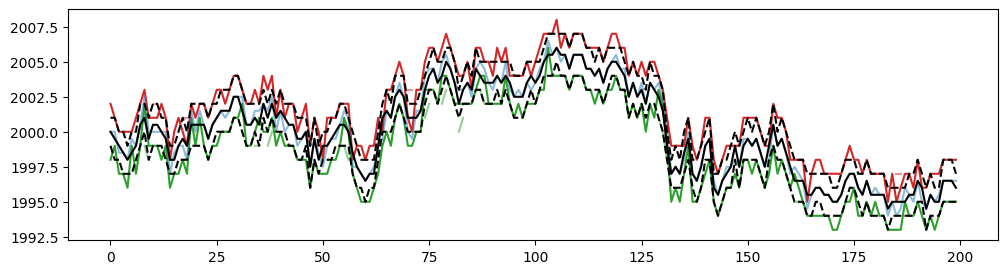

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(price['timestamp']//100, price['bid_price_1'], c='tab:green')
plt.plot(price['timestamp']//100, price['bid_price_2'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['bid_price_3'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_1'], c='tab:red')
plt.plot(price['timestamp']//100, price['ask_price_2'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_3'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

## Price prediction

In [12]:
train = price_0['mid_price'].to_numpy()
valid = price_1['mid_price'].to_numpy()
test = price_2['mid_price'].to_numpy()

In [13]:
train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

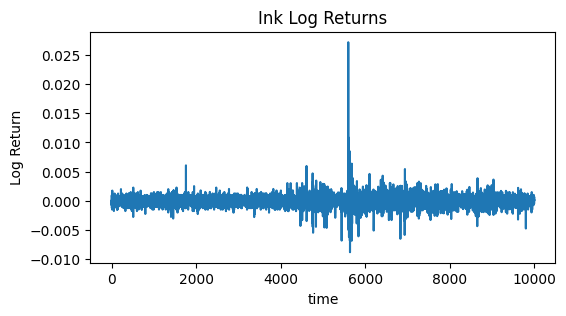

In [16]:
plt.figure(figsize=(6, 3))
plt.plot(train_logr)
plt.title('Ink Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

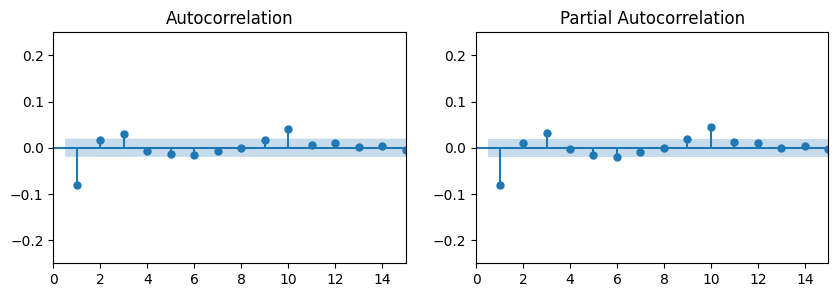

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_logr, ax=ax[0], zero=False)
plot_pacf(train_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
ax[0].set_ylim([-0.25, 0.25])
ax[1].set_ylim([-0.25, 0.25])
plt.show()